In [5]:
import tensorflow as tf
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization

In [6]:

def normalization(df):
    df = df.drop("future", 1)  # don't need this anymore.
    df = df.drop("High", 1)  # don't need this anymore.
    df = df.drop("Low", 1)  # don't need this anymore.
    df = df.drop("Open", 1)  # don't need this anymore.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    return df

In [7]:


def preprocess_df(df):
    
    df = normalization(df)
    sequential_data = []  # this is a list that will CONTAIN the sequences
    
    # These will be our actual sequences. 
    #they are made with deque, which keeps
    #the maximum length by popping out older 
    #values as new ones come in
    prev_days = deque(maxlen=SEQ_LEN)  

    for i in df.values:  # iterate over the values
    
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 10 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # i[-1] is the sequence target

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?
    
    # for blancing dataset
    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)


    
    return np.array(X), y  # return X and y...and make X a numpy array!

In [8]:

SEQ_LEN = 8 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 20  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.



In [9]:
def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0

In [10]:
filename = 'BTC-USD.csv'
#dataset ='/content/gdrive/My Drive/market prediction codes/' + filename
main_df = pd.read_csv(filename )  # read in specific file
main_df['timestamp'] = main_df['Date'] #+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('Date' ,1)
#main_df  = main_df.drop('time',1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)

main_df['future'] = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df['Close'], main_df['future']))



#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 5% of the times

validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%
print(main_df.head())
print(main_df.describe())

                    Open          High           Low         Close  \
timestamp                                                            
2019-08-31   9597.539063   9673.220703   9531.799805   9630.664063   
2019-09-01   9630.592773   9796.755859   9582.944336   9757.970703   
2019-09-02   9757.473633  10396.591797   9730.650391  10346.760742   
2019-09-03  10345.725586  10736.104492  10308.547852  10623.540039   
2019-09-04  10621.180664  10762.644531  10434.709961  10594.493164   

               Adj Close       Volume        future  target  
timestamp                                                    
2019-08-31   9630.664063  11454806419   9757.970703       1  
2019-09-01   9757.970703  11445355859  10346.760742       1  
2019-09-02  10346.760742  17248102293  10623.540039       1  
2019-09-03  10623.540039  19384917988  10594.493164       0  
2019-09-04  10594.493164  16742664768  10575.533203       0  
               Open          High           Low         Close     Adj Close

In [11]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)
print(train_x.shape)
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")


(276, 8, 3)
train data: 276 validation: 56
Dont buys: 138, buys: 138
VALIDATION Dont buys: 28, buys: 28


In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [13]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 128)            67584     
_________________________________________________________________
dropout (Dropout)            (None, 8, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [14]:

history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, np.array(validation_y)))


Train on 276 samples, validate on 56 samples
Epoch 1/20
276/276 [==============================] - 9s 32ms/sample - loss: 0.9298 - accuracy: 0.5217 - val_loss: 0.6930 - val_accuracy: 0.4643
Epoch 2/20
276/276 [==============================] - 0s 931us/sample - loss: 0.8155 - accuracy: 0.5435 - val_loss: 0.6927 - val_accuracy: 0.5179
Epoch 3/20
276/276 [==============================] - 0s 956us/sample - loss: 0.7775 - accuracy: 0.5290 - val_loss: 0.6924 - val_accuracy: 0.4821
Epoch 4/20
276/276 [==============================] - 0s 923us/sample - loss: 0.7198 - accuracy: 0.5580 - val_loss: 0.6917 - val_accuracy: 0.4821
Epoch 5/20
276/276 [==============================] - 0s 1ms/sample - loss: 0.7778 - accuracy: 0.5435 - val_loss: 0.6918 - val_accuracy: 0.5536
Epoch 6/20
276/276 [==============================] - 0s 985us/sample - loss: 0.7368 - accuracy: 0.5326 - val_loss: 0.6924 - val_accuracy: 0.5536
Epoch 7/20
276/276 [==============================] - 0s 949us/sample - loss: 0.71

Test loss: 0.6868303758757455
Test accuracy: 0.5535714


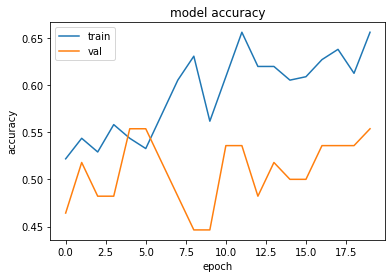

In [15]:
score = model.evaluate(validation_x, np.array(validation_y), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


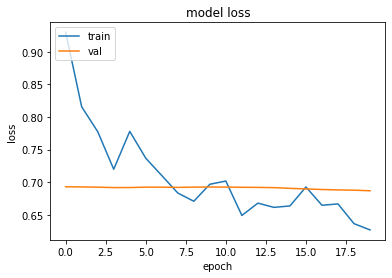

In [16]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()